In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
from utils.fin_utils import download_data, calculate_parametric_var, age_weight_series
import datetime as dt
import yfinance as yf
from typing import List, Tuple
from const.numbers import *
import const.literals as c
from utils.logger import get_logger


logger = get_logger(__name__)



# <font face="gotham" color="purple"> Value at Risk</font>

Though returns are hardly normal distribution, they can be seen as a linear combination of standard normal distribution
$$
r(t) = \mu+ \sigma*N(0, 1)
$$

With this knowledge, we can characterize losses in price units, for instance we can phrase 'with 5% significance level your portfolio could lose at least $23000 next week'.

$$
\text{Prob}(\delta \pi\leq -\text{VaR}) = 1-\text{Confi. Lvl.}
$$
where $\delta \pi$ means the change of portfolio.

Here's how you translate the time interval
$$
\sigma_{\text{n-day}} = \sigma_{\text{daily}}\sqrt{n}\\
\mu_{\text{n-day}} = \mu_{\text{daily}}n
$$

# <font face="gotham" color="purple"> Parametric VaR</font>

This is the formula of $\text{VaR}$
$$
\text{VaR} =  |(\underbrace{\mu \delta t}_{\text{from }  \mu_{\text{daily}}n} -\underbrace{\sigma \sqrt{\delta t}}_{\text{from }\sigma_{\text{daily}}\sqrt{n}})F^{-1}(1-C)|
$$
where $F^{-1}$ is the inverse cumulative (mostly we use normal) distribution function.

As an example, our portfolio has annual mean of 0.14, annual volatility of 0.32, we would like to know the 99% 1-Week VaR. That would be
$$
\text{99\%VaR}_{1w} =|( \underbrace{0.14/52}_{\text{from }  \mu_{\text{daily}}n} -\underbrace{0.32/ \sqrt{52}}_{\text{from }\sigma_{\text{daily}}\sqrt{n}})\times 1.965| \approx 0.081

$$
So we can say this portfolio has risk of losing at least $8.1\%$ in a most recent week horizon.


Imagine a long-only portfolio with three stocks, we will calculate the portfolio pnl.

In [2]:
data = download_data(
    security=['AAPL', 'LULU', 'C'], 
    dropna=True, 
    start_date=dt.date(2020, 1, 1), 
    end_date=dt.date(2024, 1, 1) 
)

portfolio_returns = data.pct_change()
weights = np.array([0.5, 0.3, 0.2])
portfolio_returns[c.PORTFOLIO_RETURN] = portfolio_returns.dot(weights)

<Axes: xlabel='Date'>

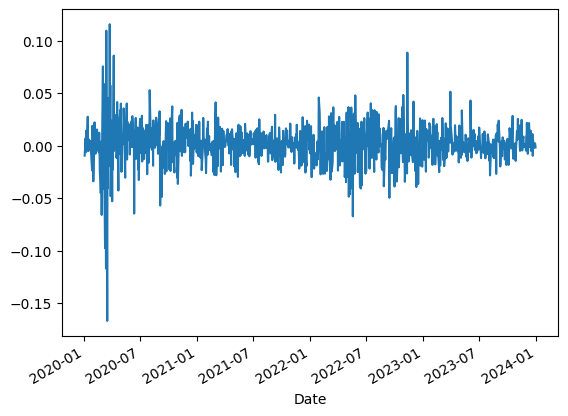

In [3]:
portfolio_returns[c.PORTFOLIO_RETURN].plot()

In [4]:

para_95_1d_var = calculate_parametric_var(
    value=MILLION, 
    confidence=PERCENTILE_95, 
    mu=portfolio_returns[c.PORTFOLIO_RETURN].mean(), 
    sigma=portfolio_returns[c.PORTFOLIO_RETURN].std()
)
logger.info("portfolio of %s value, 1D 95%% VaR: %s", MILLION, para_95_1d_var)

2024-06-01 20:53:39,011 - __main__ - INFO - portfolio of 1000000.0 value, 1D 95% VaR: 32816.01725350202


# <font face="gotham" color="purple"> Age-Weighted Historical Simulation</font>

We can use exponential weights to reduce Ghost effect of VaR, which is a phenomenon that VaR's sudden jump without any obvious recent volatility. 

In [5]:
age_weights = age_weight_series(num_period=len(portfolio_returns), decay_param=0.99)

In [6]:
age_weights.index = portfolio_returns.index.sort_values(ascending=False)

<Axes: xlabel='Date'>

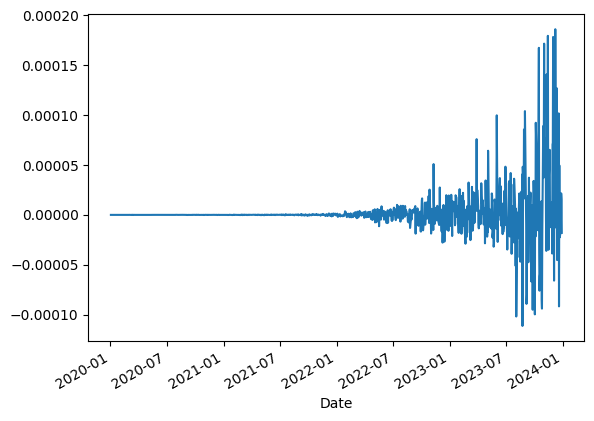

In [7]:

aged_weighted_return = portfolio_returns[c.PORTFOLIO_RETURN].dropna()*age_weights
aged_weighted_return.plot()

In [12]:
aged_weighted_return

Date
2020-01-02 00:00:00-05:00             NaN
2020-01-03 00:00:00-05:00   -3.993985e-09
2020-01-06 00:00:00-05:00    2.913282e-09
2020-01-07 00:00:00-05:00   -2.662697e-09
2020-01-08 00:00:00-05:00    6.047657e-09
                                 ...     
2023-12-22 00:00:00-05:00   -2.258174e-05
2023-12-26 00:00:00-05:00   -1.647288e-05
2023-12-27 00:00:00-05:00    2.158052e-05
2023-12-28 00:00:00-05:00    1.572282e-05
2023-12-29 00:00:00-05:00   -1.803182e-05
Length: 1006, dtype: float64

In [13]:
confidence_level = 0.95
np.percentile(aged_weighted_return.dropna(),  (1 - confidence_level) * 100)

-1.8600768074835194e-05